# Comparison of the Coronavirus outbreak among countries

Sunday, March 8, 2020

This notebook is intended to check what is the oubreak evolution in each country, and to some extent to forecast what may be the next steps: some countries were exposed after some others, and **we have the opportunity to see the path they followed and to compare it to the countries that are now exposed.**

China, and now Italy are providing statistics that can be used for this purpose.
This notebook shows that France is roughly following the same path 9 days later, and the USA too.
**We are using the number of deaths to study the outbreak, as those numbers may prove more precise than the case numbers, which are subject to different policies among countries.**

What we can note is that the **initial natural trend is doubling of the deaths every 2 days**. This is very fast, as some pandemics show that this doubling is usually observed every 6 days.
**China deaths curve show a large slowing down of the outbreak after this initial phase, that may related to a very strong policy to contain it.**
**Italy shows no slowdown since the beginning**, we are still in this early phase. The next days will show if the curve follows China curve, or if the exponential growth will go on for more days.
It's probably too early for France and USA to conclude, but the trend is very similar right now.

**Following graphs are using logarithmic scale, because that's the right thing to do when processing data about an exponential process. That should not hide the fact that the growth is much more severe that what those graphs seems to convey.**




In [34]:
import urllib
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import math
import json

%matplotlib notebook

def get_data(country):    
    url = "https://en.wikipedia.org/w/index.php?title=Template:"
    sep = "-" if country == "Spain" else "%E2%80%93"
    url += "2019%s20_coronavirus_outbreak_data/%s_medical_cases_chart&action=raw" % (sep, country)

    data = urllib.request.urlopen(url).read()    
    ret = str(data, "utf8")
    return ret

def postprocess(e, country):
    infos = []
    for l in e.splitlines():
        if "bar stacked" in l.lower() or "bar_stacked" in l.lower():
            info = l.split("|")
#            print(info)
            if info[1] in ["----------", "{{nowrap"]:
                continue
            
            if country == "China":
                case_info = info[4]
                death_info = info[6]
                if case_info == '':
                    case_info = info[2]
                    death_info = info[6]
 
                if death_info == "(1367-108)":
                    death_info = str(1367+108)
            else:
                case_info = info[2]
                death_info = info[4]
                
            case_info = case_info.replace("{{#expr:", "").replace("}}", "").replace(",","")
            death_info = death_info.replace("{{#expr:", "").replace("}}", "").replace(",","")

#            print(info)
            d = {}
            d["date"] = datetime.datetime.strptime(info[1][:10], '%Y-%m-%d').isoformat()
            d["cases"] = int(case_info.split("&")[0].replace(",", ""))
            d["deaths"] = int(death_info.replace("{{#expr: ","").split("/")[0].replace(",", ""))
            infos.append(d)
    return infos

def get_data_per_country(country, reset = False):
    p = pathlib.Path("data") / "wikipedia" / ("%s.json" % country)
    
    if not reset and p.exists():
        ret = json.loads(open(p).read())
        return ret
    else:        
        data = get_data(country)    
        ret = postprocess(data, country)
        if reset or not p.exists():
            j = json.dumps(ret, sort_keys=True, indent=4, separators=(',', ': '))
            f = open(p, "w")
            f.write(j)
    
    return ret
        
countries = ["China", "France", "South_Korea", "Italy", "United_States", "Germany", "Iran", "Spain"]
# Update Data from wikipedia:
update = False
if update:
    for c in countries:
        get_data_per_country(c, reset = True)

china_offset= 36
offset_by_country = dict(France=-9 - china_offset, 
                         Italy=0 - china_offset, 
                         Germany=-9 - china_offset, 
                         United_States=-8 - china_offset,
                         South_Korea=0 - china_offset,
                         Iran=2 - china_offset,
                         Japan=30 - china_offset,
                         Spain=-10 - china_offset)



In [35]:
def plot_date_values(values, offset, multiplier, log_axis, label, key):
    start_time = datetime.datetime(2020, 1, 1)
    dates = [(datetime.datetime.fromisoformat(v["date"]) - start_time).days  + offset for v in values]
    y = [v[key] * multiplier for v in values]
    if log_axis:
        y = [a for a in y]
    if log_axis:
        plt.yscale("log")

   
    plt.plot(dates, y, label = label + " %d days" % offset)
    
def finalize_plot_comparison(key, start, end, reference_shift):
    plt.plot([max(1, 2**((x - reference_shift)* 0.5)) for x in range(0, 40)], label="Doubling every two days")

    _ = plt.legend()
    plt.title("%s by country over time.\n Logarithmic scale.\n X axis is custom shifted for each country to take into account different start time." % key.capitalize(),
            fontdict = {'fontweight' : "bold", 'verticalalignment': 'baseline'})
    plt.xlabel("Days since 01-01-2020 (for China, use offset for other countries)")
    plt.ylabel(key)
    plt.xlim(start, end)

def plot_comparison(countries, key, start = 8, end = 78, reference_shift = 13):
    """Key parameters is 'cases' or 'deaths'"""
    log_axis = True

   

    default_offset = 0
    # This dictionary can be used to correct for different countries testing policies
    multiplier_by_country = dict()
    default_multiplier = 1
    
    fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

#    fig, axs = plt.subplots(len(countries), 1)

    for i, country in enumerate(countries):

#        print("country=", country)
        data_for_country = get_data_per_country(country)
    #    break
        plot_date_values(data_for_country,
                         offset_by_country.get(country, default_offset),
                         multiplier_by_country.get(country, default_multiplier),
                         log_axis, country, key)
    finalize_plot_comparison(key, start, end, reference_shift)
    
        

<IPython.core.display.Javascript object>


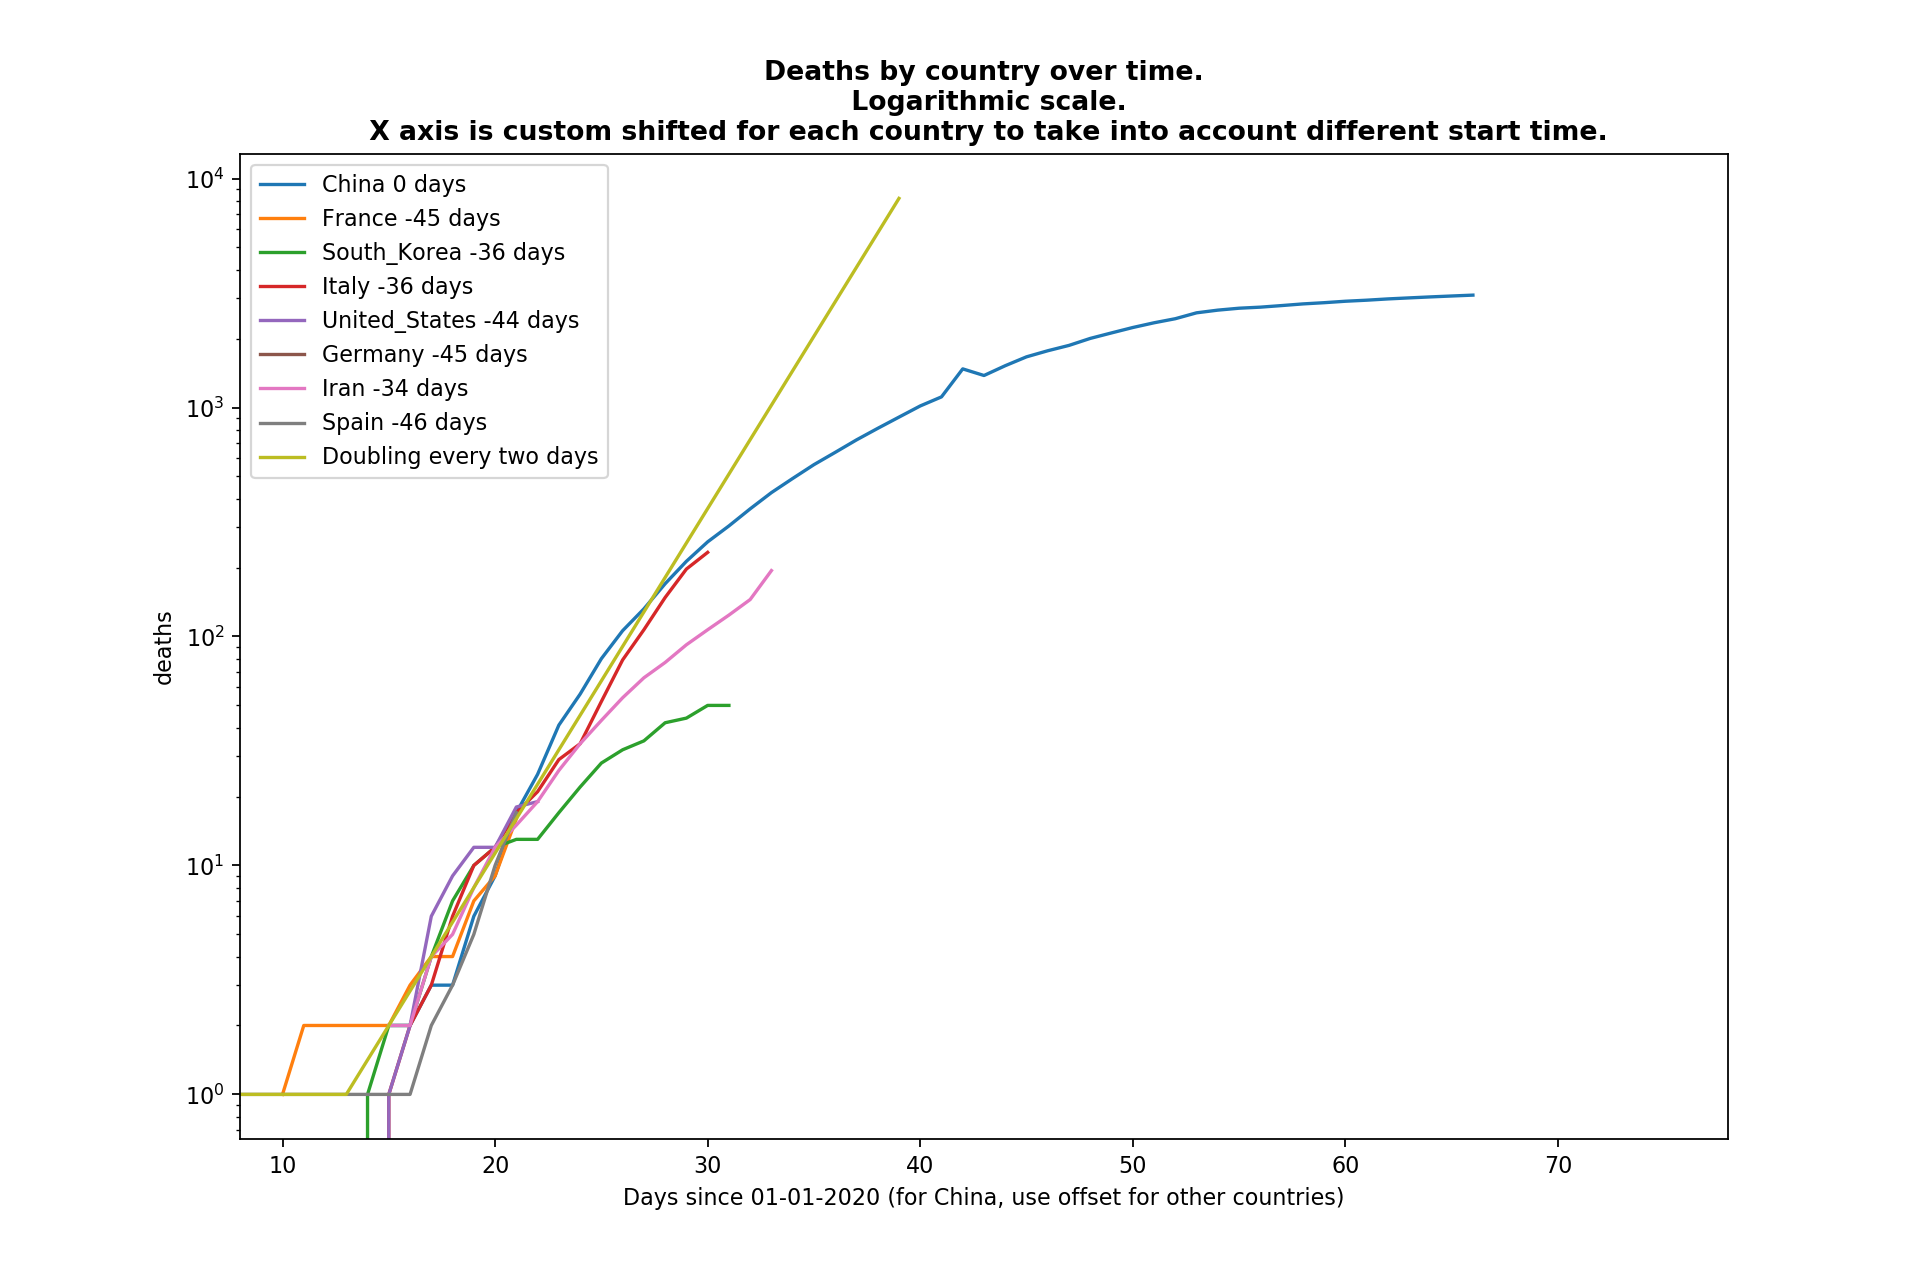

In [36]:
countries = ["China", "France", "South_Korea", "Italy", "United_States", "Germany", "Iran", "Spain"]
plot_comparison(countries, "deaths")


# Notes on number of deaths

## Time offsets
China obviously came first.
Italy and South Korea almost at the same time, 36 days later.
Then France and USA are roughly 9 days behind Italy and South Korea.
It's important to note this, as you can tell somehow what will happen to you by looking at the previous countries.

## South Korea
From the graphics, it looks like *South Korea* is doing quite well to limit the number of deaths.
It looks like too that there was at least two steps in the growth, one stabilizing at 12 deaths, and a second growth stabilizing at 44.

## Italy
The curve for *Italy* is much more worrying : no inflection is visible right now, the growth is still exponential.

## United States
It's a bit early to be sure of anything, but the curve clearly follow an exponential growth right now

## France
A first cluster appeared early, explaining the early start, and a second wave has started. Right now it's difficult to judge of the trend.



<IPython.core.display.Javascript object>


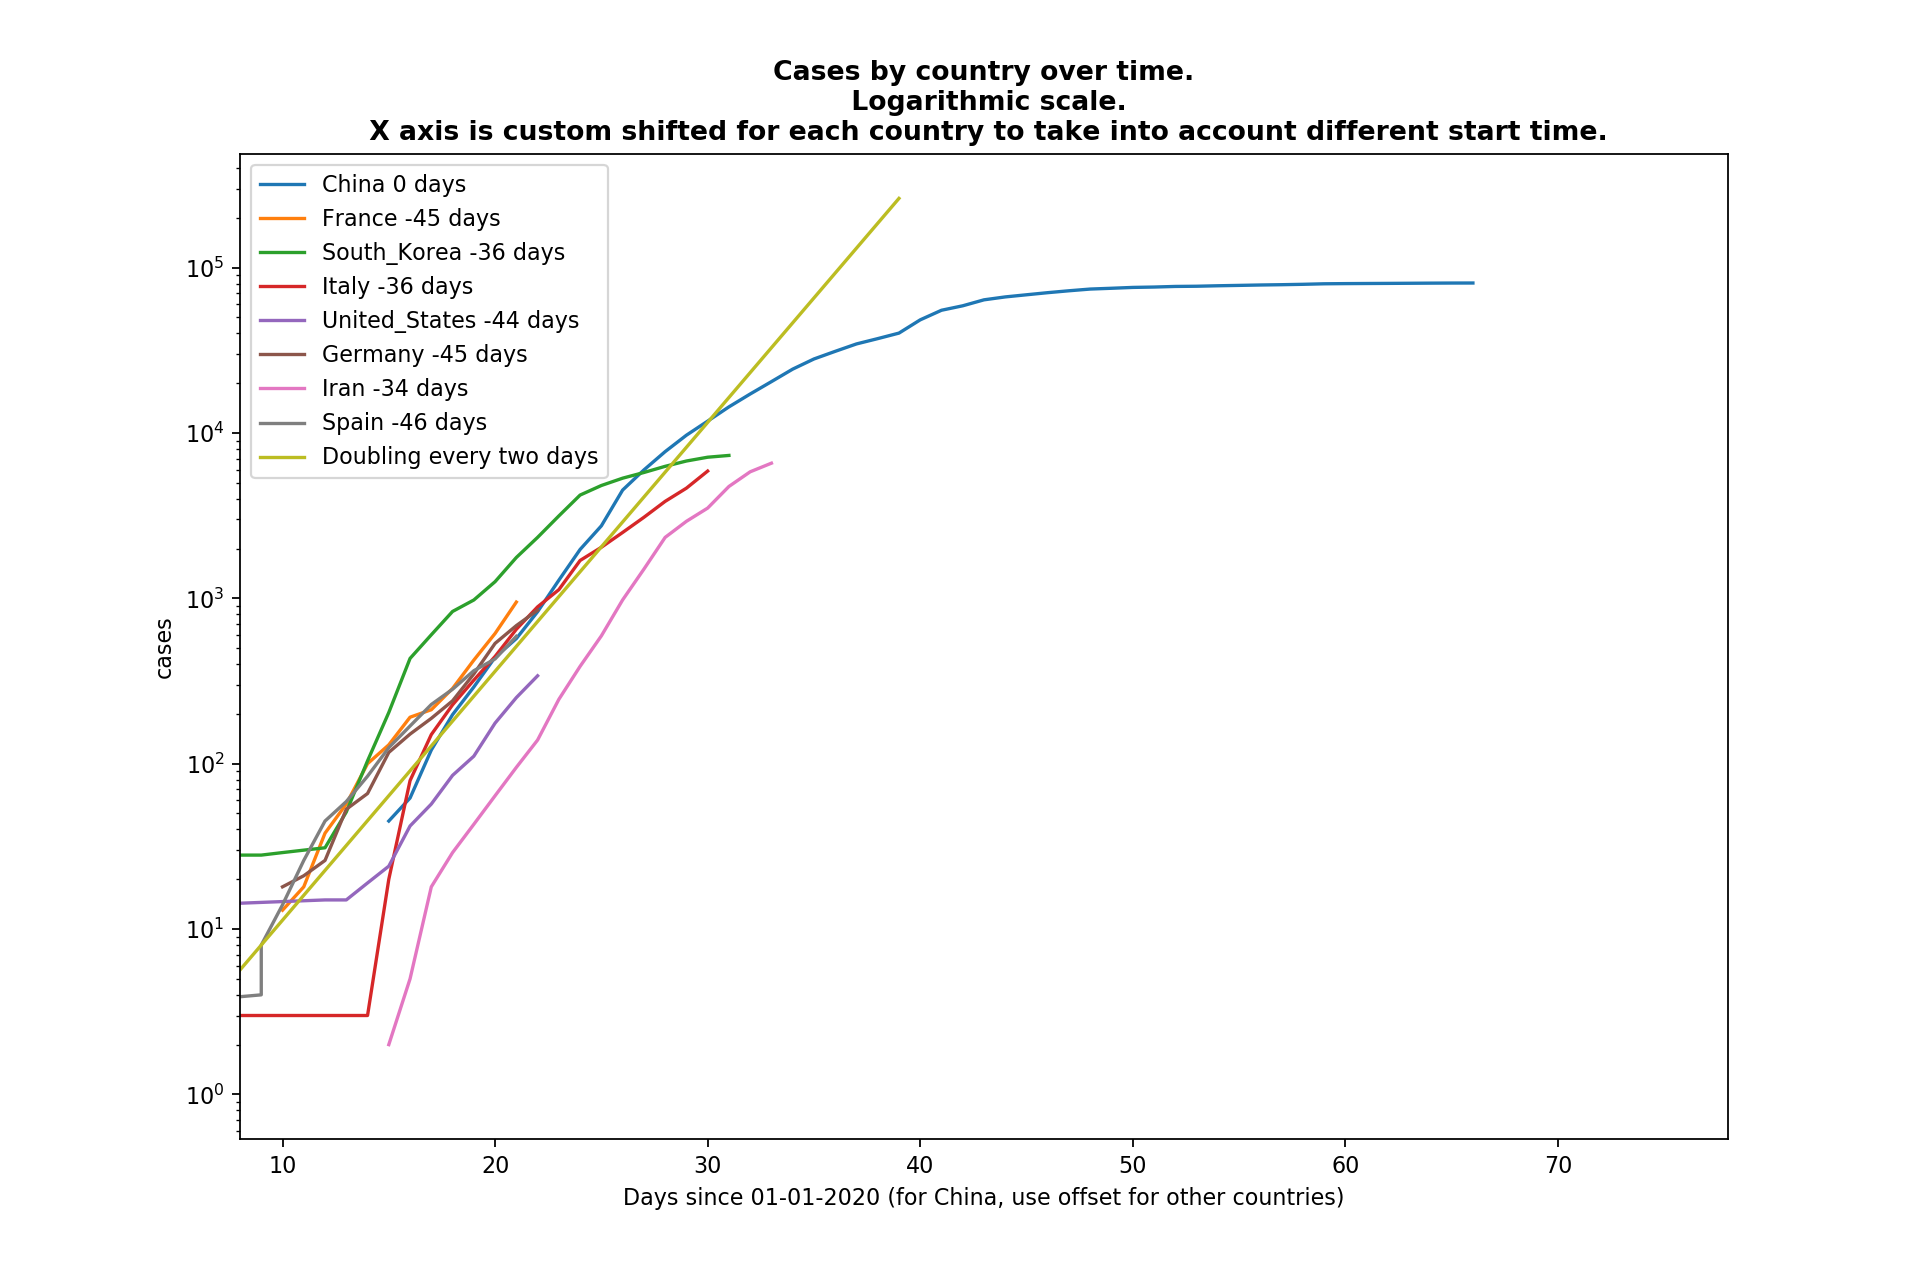

In [37]:

plot_comparison(countries, "cases", reference_shift= 3)

# Notes on numbers of cases

We are using there the same time shifts we used for the deaths.
It's apparent that the different curves are separated.
My interpretation is that the testing policies of the different countries are very different, so you have to compensate for this (South Korea and Italy did a lot of tests).




